In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix,accuracy_score,r2_score

C:\Users\chgay\anaconda3\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.26.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
columns=["id","cycle","op1","op2","op3","sensor1","sensor2","sensor3","sensor4","sensor5","sensor6","sensor7","sensor8",
         "sensor9","sensor10","sensor11","sensor12","sensor13","sensor14","sensor15","sensor16","sensor17","sensor18","sensor19"
         ,"sensor20","sensor21","sensor22","sensor23"]

In [3]:
train=pd.read_csv("train_FD001.txt",sep=" ",names=columns)
test=pd.read_csv("test_FD001.txt",sep=" ",names=columns)
test_result=pd.read_csv("RUL_FD001.txt",sep=" ",header=None)

In [4]:
train.head()

,id,cycle,op1,op2,op3,sensor1,sensor2,sensor3,sensor4,sensor5,...,sensor14,sensor15,sensor16,sensor17,sensor18,sensor19,sensor20,sensor21,sensor22,sensor23
0,1,1,-0.0007,-0.0004,100.0,518.67,641.82,1589.70,1400.60,14.62,...,8138.62,8.4195,0.03,392,2388,100.0,39.06,23.4190,NaN,NaN
1,1,2,0.0019,-0.0003,100.0,518.67,642.15,1591.82,1403.14,14.62,...,8131.49,8.4318,0.03,392,2388,100.0,39.00,23.4236,NaN,NaN
2,1,3,-0.0043,0.0003,100.0,518.67,642.35,1587.99,1404.20,14.62,...,8133.23,8.4178,0.03,390,2388,100.0,38.95,23.3442,NaN,NaN
3,1,4,0.0007,0.0000,100.0,518.67,642.35,1582.79,1401.87,14.62,...,8133.83,8.3682,0.03,392,2388,100.0,38.88,23.3739,NaN,NaN
4,1,5,-0.0019,-0.0002,100.0,518.67,642.37,1582.85,1406.22,14.62,...,8133.80,8.4294,0.03,393,2388,100.0,38.90,23.4044,NaN,NaN


## Engine cycle Lifetime

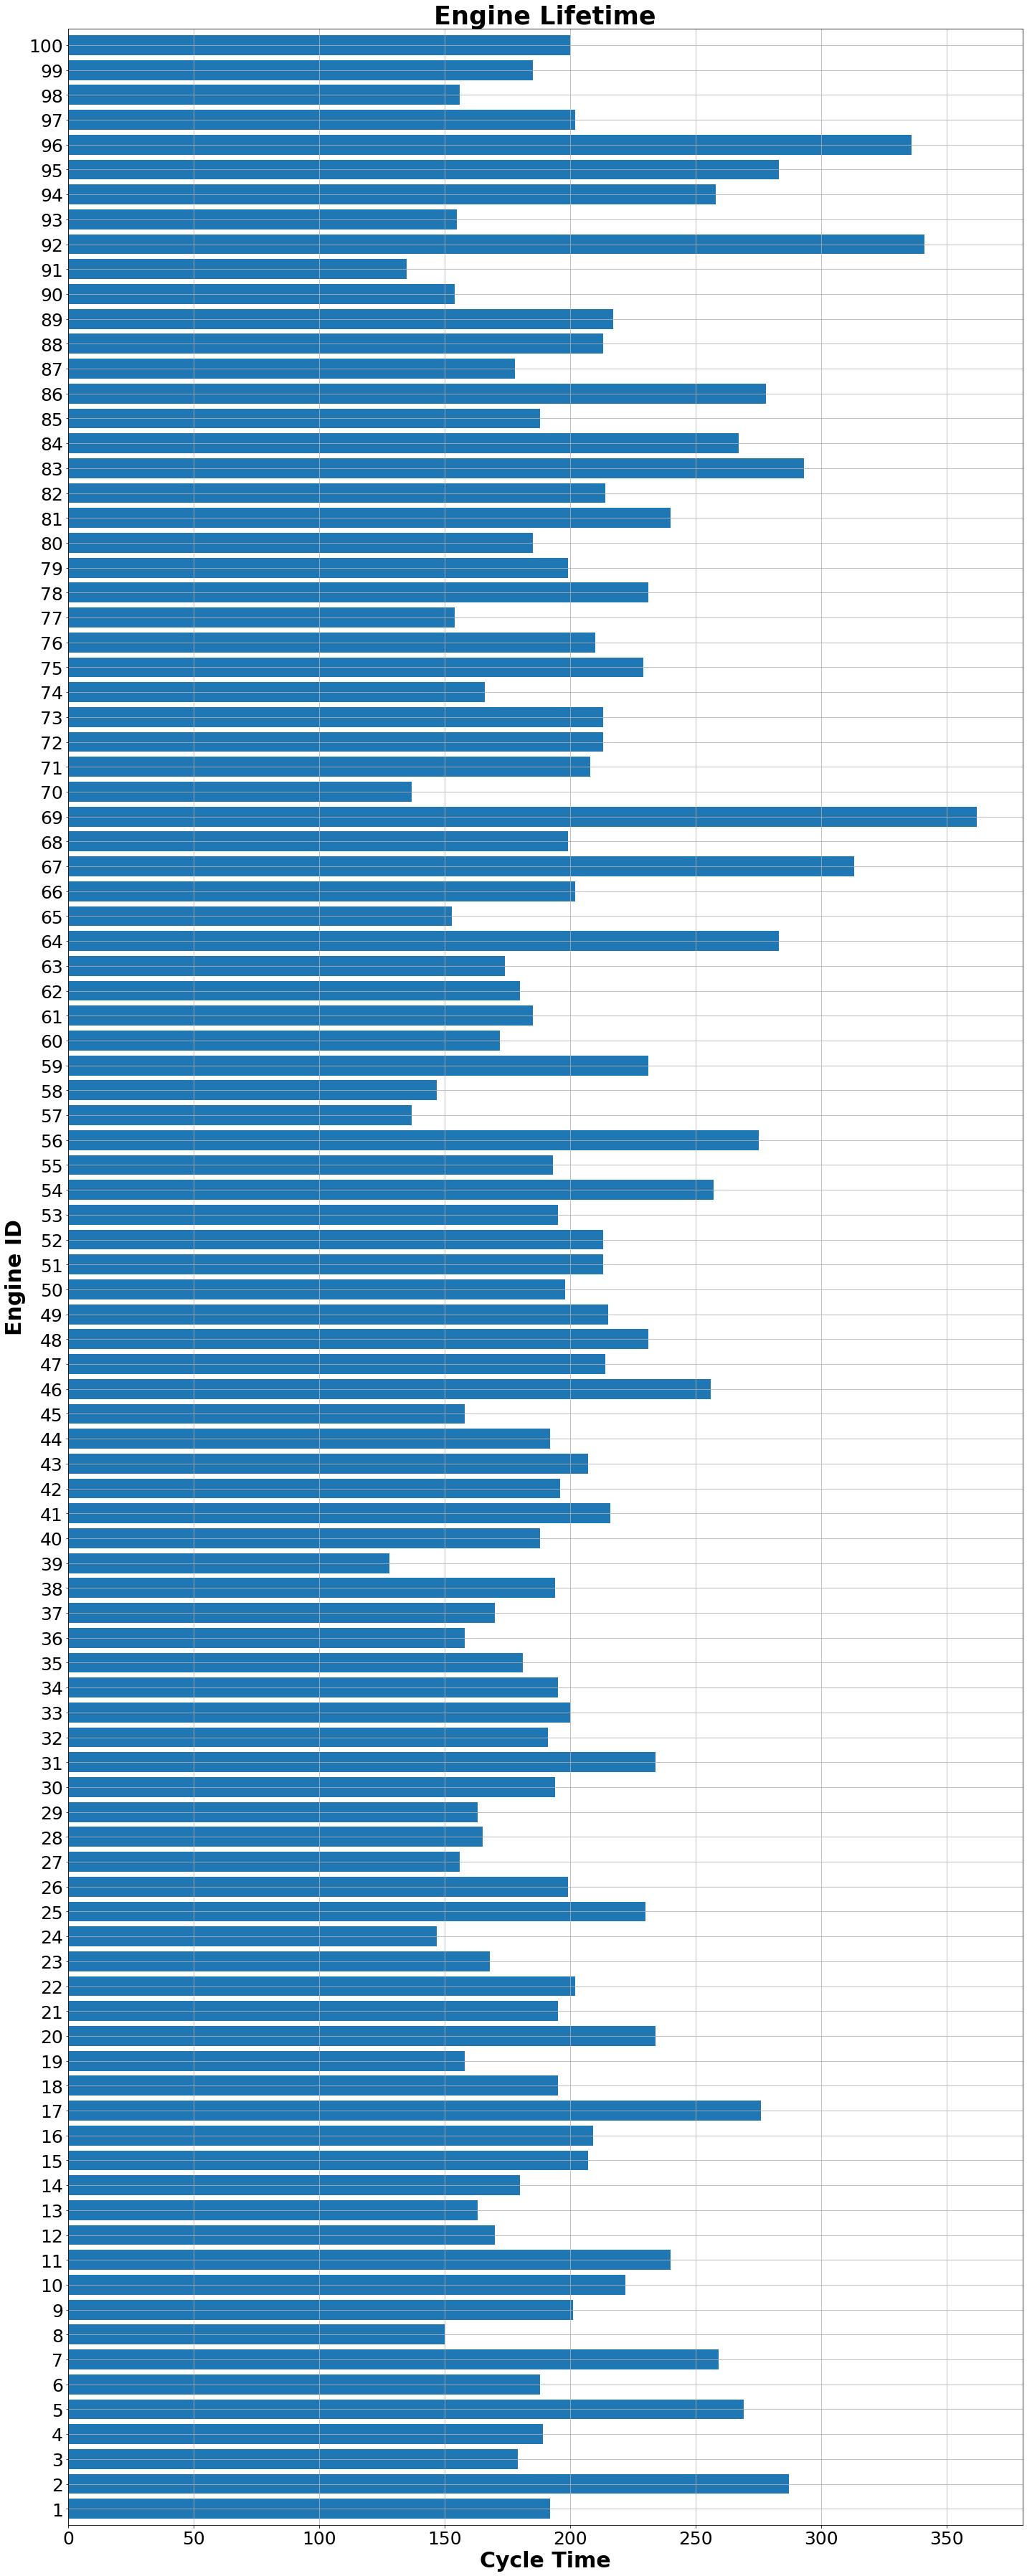

In [5]:
plt.figure(figsize=(20,50))
ax=train.groupby('id')['cycle'].max().plot(kind="barh",width=0.8,stacked=True,align='center',rot=0)
plt.title("Engine Lifetime",fontweight='bold',size=35)
plt.xlabel("Cycle Time",fontweight='bold',size=30)
plt.xticks(size=25)
plt.ylabel('Engine ID',fontweight='bold',size=30)
plt.yticks(size=25)
plt.grid(True)
plt.tight_layout()
plt.show()

In [6]:
test_result.columns=["rul","null"]
test_result.head()

,rul,null
0,112,NaN
1,98,NaN
2,69,NaN
3,82,NaN
4,91,NaN


In [7]:
test_result.drop(["null"],axis=1,inplace=True)
test_result["id"]=test_result.index+1
test_result.head()

,rul,id
0,112,1
1,98,2
2,69,3
3,82,4
4,91,5


In [8]:
rul=pd.DataFrame(test.groupby('id')['cycle'].max()).reset_index()
rul.columns=['id','max']

In [9]:
test_result['rul_failed']=test_result["rul"]+rul["max"]
test_result.head()

,rul,id,rul_failed
0,112,1,143
1,98,2,147
2,69,3,195
3,82,4,188
4,91,5,189


In [10]:
test_result.drop(['rul'],axis=1,inplace=True)

In [11]:
test=test.merge(test_result,on=['id'],how='left')

In [12]:
test["remaining_cycle"]=test["rul_failed"]-test["cycle"]
test.head()

,id,cycle,op1,op2,op3,sensor1,sensor2,sensor3,sensor4,sensor5,...,sensor16,sensor17,sensor18,sensor19,sensor20,sensor21,sensor22,sensor23,rul_failed,remaining_cycle
0,1,1,0.0023,0.0003,100.0,518.67,643.02,1585.29,1398.21,14.62,...,0.03,392,2388,100.0,38.86,23.3735,NaN,NaN,143,142
1,1,2,-0.0027,-0.0003,100.0,518.67,641.71,1588.45,1395.42,14.62,...,0.03,393,2388,100.0,39.02,23.3916,NaN,NaN,143,141
2,1,3,0.0003,0.0001,100.0,518.67,642.46,1586.94,1401.34,14.62,...,0.03,393,2388,100.0,39.08,23.4166,NaN,NaN,143,140
3,1,4,0.0042,0.0000,100.0,518.67,642.44,1584.12,1406.42,14.62,...,0.03,391,2388,100.0,39.00,23.3737,NaN,NaN,143,139
4,1,5,0.0014,0.0000,100.0,518.67,642.51,1587.19,1401.92,14.62,...,0.03,390,2388,100.0,38.99,23.4130,NaN,NaN,143,138


In [14]:
df_train=train.drop(["sensor22","sensor23"],axis=1)
df_test=test.drop(["sensor22","sensor23"],axis=1)

In [15]:
df_train["remaining_cycle"]= df_train.groupby(['id'])['cycle'].transform(max)-df_train['cycle']

In [16]:
cycle=30
df_train['label']=df_train["remaining_cycle"].apply(lambda x : 1 if x<=cycle else 0)
df_test['label']=df_test["remaining_cycle"].apply(lambda x : 1 if x<=cycle else 0)

In [17]:
op_set=["op"+str(i) for i in range(1,4)]
sensor=["sensor"+str(i) for i in range(1,22)]

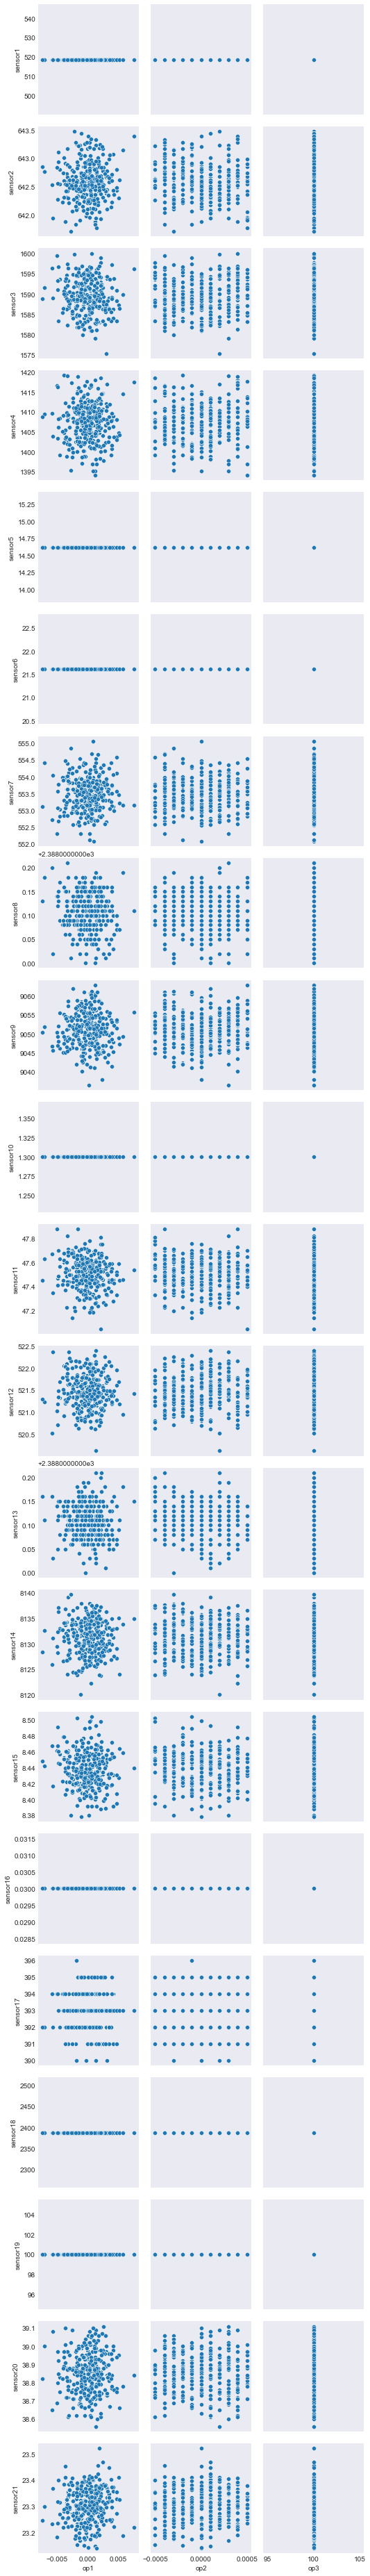

In [18]:
plt.style.use("seaborn-dark")
ax=sns.pairplot(test.query("cycle"),x_vars=op_set,y_vars=sensor,palette="hus1")

In [19]:
df_test.drop(["id","op3","sensor1","sensor5","sensor6","sensor10","sensor16","sensor18","sensor19"],axis=1,inplace=True)

In [20]:
x=df_train.drop(["id","cycle","op3","sensor1","sensor5","sensor6","sensor10","sensor16","sensor18","sensor19","remaining_cycle","label"],axis=1)
y=df_train.label

print('x shape :',x.shape)
print('y shape :',y.shape)

x shape : (20631, 16)
y shape : (20631,)


## Model creation

## Regression Model

In [48]:
x=df_train.drop(["id","op3","sensor1","sensor5","sensor6","sensor10","sensor16","sensor18","sensor19","remaining_cycle","label"],axis=1)
y=df_train['remaining_cycle']
print('x shape : ',x.shape)
print('y shape : ',y.shape)

x shape :  (20631, 17)
y shape :  (20631,)


In [52]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test=train_test_split(x,y, test_size=0.2, random_state=3)
print('X_train shape : ',x_train.shape)
print('X_test shape : ',x_test.shape)
print('y_train shape : ',y_train.shape)
print('y_test shape : ',y_test.shape)

X_train shape :  (16504, 17)
X_test shape :  (4127, 17)
y_train shape :  (16504,)
y_test shape :  (4127,)


In [53]:
from sklearn.ensemble import RandomForestRegressor,GradientBoostingRegressor
from sklearn.metrics import mean_absolute_error,mean_squared_error,r2_score
# import xgboost as xgb
# import lightgbm as lgb

In [54]:
rf_regressor=RandomForestRegressor(n_jobs=-1,n_estimators=400)
rf_regressor.fit(x_train,y_train)
y_pred_rf=rf_regressor.predict(x_test)

mae=mean_absolute_error(y_test,y_pred_rf)
mse=mean_squared_error(y_test,y_pred_rf)
rmse=np.sqrt(mse)
r2=r2_score(y_test,y_pred_rf)
print(f'Model : RandomForestRegressor \n  MAE : {mae}\n  MSE : {mse}\n RMSE: {rmse}\n R2 score: {r2}\n')

Model : RandomForestRegressor 
  MAE : 25.246137024472983
  MSE : 1317.6355953159075
 RMSE: 36.29925061645085
 R2 score: 0.7200738684392314



In [38]:
y_pred_rf=rf_regressor.predict(df_test.drop(["label","remaining_cycle","rul_failed"],axis=1))

In [39]:
df_test["remaining_cycle"]

0        142
1        141
2        140
3        139
4        138
        ... 
13091     24
13092     23
13093     22
13094     21
13095     20
Name: remaining_cycle, Length: 13096, dtype: int64

In [40]:
df_excel=pd.DataFrame(y_pred_rf,columns=["RUL-predicted"])

In [41]:
df_excel["TRUE-RUL"]=df_test["remaining_cycle"]

In [42]:
df_excel.to_csv("result.csv")

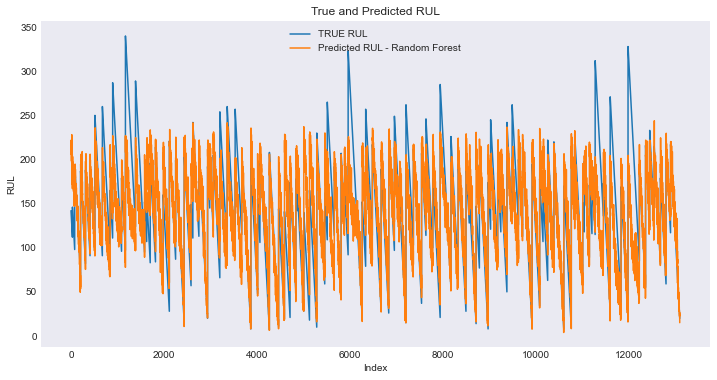

In [43]:
plt.figure(figsize=(12,6))
plt.plot(df_test["remaining_cycle"],label='TRUE RUL')
plt.plot(y_pred_rf,label="Predicted RUL - Random Forest")
plt.xlabel('Index')
plt.ylabel('RUL')
plt.title('True and Predicted RUL')
plt.legend()
plt.show()